In [1]:
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from dataandcoords import set_data_and_coords
from gpapproximation import make_gp_basis
from posteriorplots import predictive_plot, retrodictive_plot
from zerosumnormal import ZeroSumNormal

if pm.math.erf.__module__.split(".")[0] == "theano":
    import theano.tensor as aet
else:
    import aesara.tensor as aet

In [2]:
%load_ext autoreload
%autoreload 2

In [38]:
arviz.style.use("arviz-darkgrid")
ELECTION_DAY = "2017-04-23"
PARTIES_COMPLETE = [
    "farleft",
    "left",
    "center",
    "right",
    "farright",
    "other",
]
RANDOM_SEED = 8927
TEST_CUTOFF = pd.Timedelta(4, "W")
np.random.seed(286)

## Data

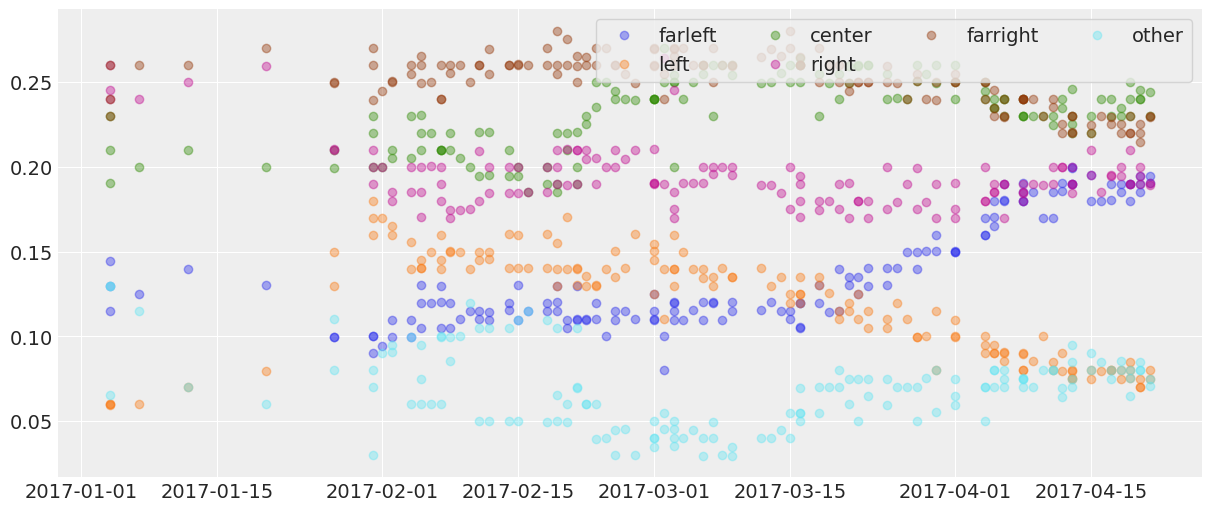

In [6]:
(
    polls_train,
    polls_test,
    results,
    observed_days_id,
    estimated_days,
    pollster_id,
    COORDS,
) = set_data_and_coords(
    election_date=ELECTION_DAY,
    parties_complete=PARTIES_COMPLETE,
    test_cutoff=TEST_CUTOFF,
)

## GP approximation

In [9]:
GP_CONFIG = {
    "lengthscale": [7, 17, 28],
    "kernel": "gaussian",
    "zerosum": True,
    "variance_limit": 0.95,
}

In [10]:
with pm.Model(coords=COORDS) as plain_mult:
    intercept = ZeroSumNormal("intercept", sigma=0.5, dims="parties_complete")
    bias = ZeroSumNormal(
        "bias", sigma=0.5, dims=("pollsters", "parties_complete"), zerosum_axes=(0, 1)
    )

    # Note: doesn't estimate cov btw parties, nor btw elections

    #   lsd_intercept = pm.Normal("lsd_intercept")
    # sd = pm.HalfNormal("lsd_party_sd")
    # raw = ZeroSumNormal("lsd_party_raw")
    # sd = tt.exp(lsd_intercept + sd * raw)

    shrinkage = pm.HalfNormal("shrinkage", 0.5)
    sd = pm.HalfNormal("time_weight", shrinkage, dims="parties_complete")
    # chol, corr, stds = pm.LKJCholeskyCov(
    #   "chol",
    #  n=len(COORDS["parties_complete"]),
    # eta=5.0,
    # sd_dist=pm.HalfNormal.dist(shrinkage),
    # compute_corr=True,
    # )
    #    pm.Deterministic("time_weight", stds, dims="parties_complete")

    gp_basis_funcs, gp_basis_dim = make_gp_basis(
        time=estimated_days, gp_config=GP_CONFIG, key="parties"
    )
    raw_coefs = ZeroSumNormal(
        f"raw_time_coefs",
        sigma=sd[None, :],
        dims=(gp_basis_dim, "parties_complete"),
        zerosum_axes=-1,
    )

    #    gps = pm.Deterministic(
    #       "time_effect",
    #      aet.dot(gp_basis_funcs, aet.tensordot(chol, raw_coefs, axes=(1, 1)).T),
    #     dims=("estimated_days", "parties_complete"),
    # )
    gps = pm.Deterministic(
        "time_effect",
        aet.dot(gp_basis_funcs, raw_coefs),
        dims=("estimated_days", "parties_complete"),
    )

    # data
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    observed_days_idx = pm.Data(
        "observed_days_idx", observed_days_id, dims="observations"
    )
    observed_N = pm.Data(
        "observed_N", polls_train["samplesize"].values, dims="observations"
    )
    observed_polls = pm.Data(
        "observed_polls",
        polls_train[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(intercept + bias[pollster_idx] + gps[observed_days_idx]),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )

    # sampling
    prior_checks = pm.sample_prior_predictive(
        var_names=["time_effect", "popularity", "N_approve"]
    )
    idata = pm.sample(return_inferencedata=True)
    post_checks = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )
    idata.extend(arviz.from_pymc3(prior=prior_checks, posterior_predictive=post_checks))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_time_coefs, time_weight, shrinkage, bias, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


0, dim: observations, 97 =? 97
1, dim: parties_complete, 1 =? 6


The number of effective samples is smaller than 10% for some parameters.


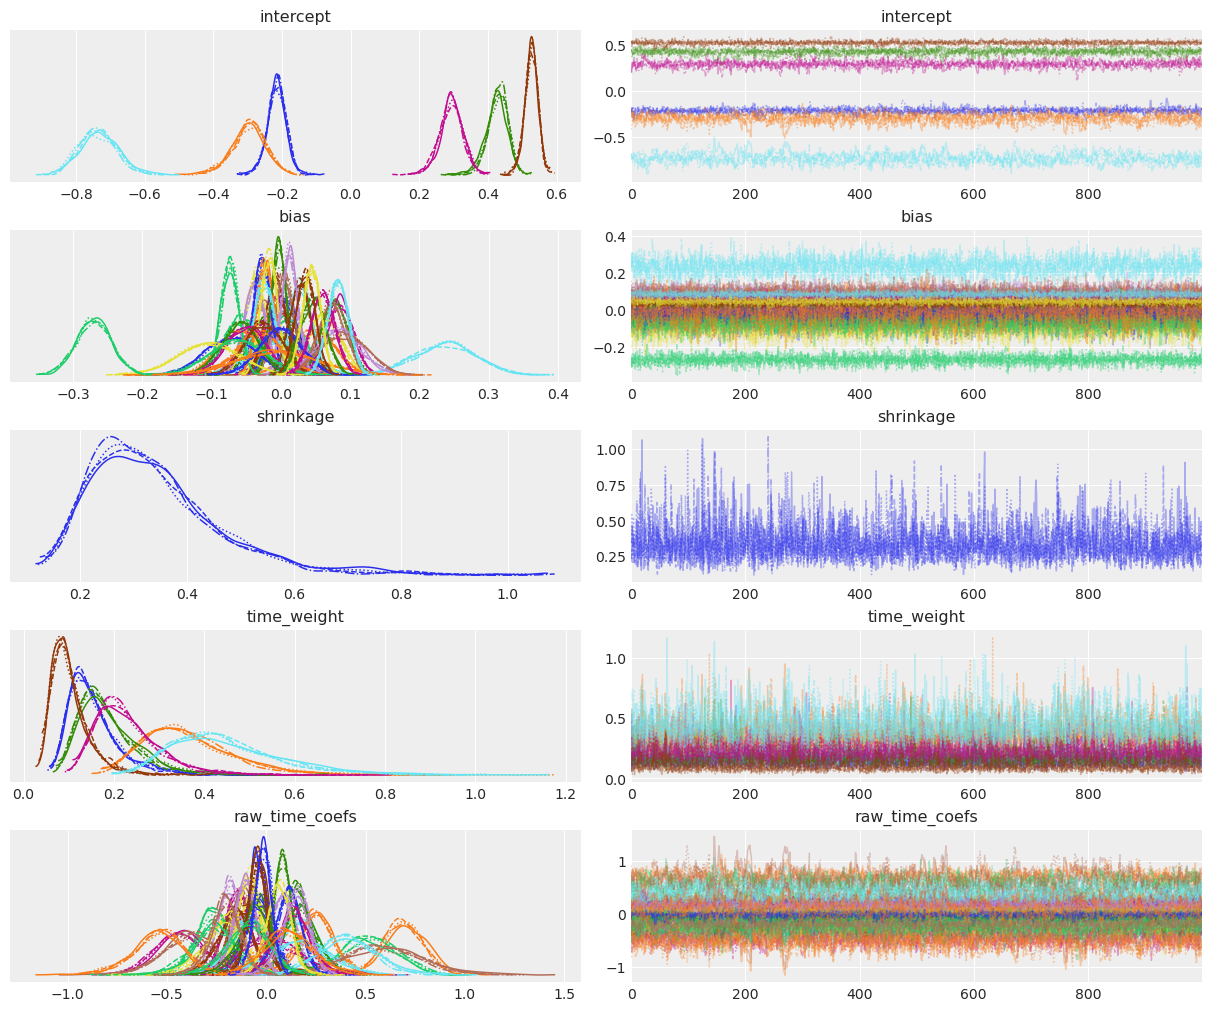

In [11]:
arviz.plot_trace(idata, var_names=["~time_effect", "~popularity"]);

In [12]:
summary = arviz.summary(
    idata,
    kind="diagnostics",
)

In [13]:
summary[summary["ess_bulk"] <= 800]

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[5],0.003,0.002,385.0,773.0,1.01
"raw_time_coefs[2,5]",0.007,0.005,437.0,824.0,1.01
"raw_time_coefs[3,1]",0.005,0.004,787.0,963.0,1.00
"raw_time_coefs[3,5]",0.008,0.006,395.0,592.0,1.02
"raw_time_coefs[4,1]",0.006,0.004,792.0,1043.0,1.00
...,...,...,...,...,...
"time_effect[108,2]",0.007,0.006,764.0,505.0,1.01
"time_effect[108,5]",0.016,0.013,371.0,527.0,1.02
"time_effect[109,1]",0.010,0.007,761.0,988.0,1.00
"time_effect[109,2]",0.007,0.006,762.0,527.0,1.01


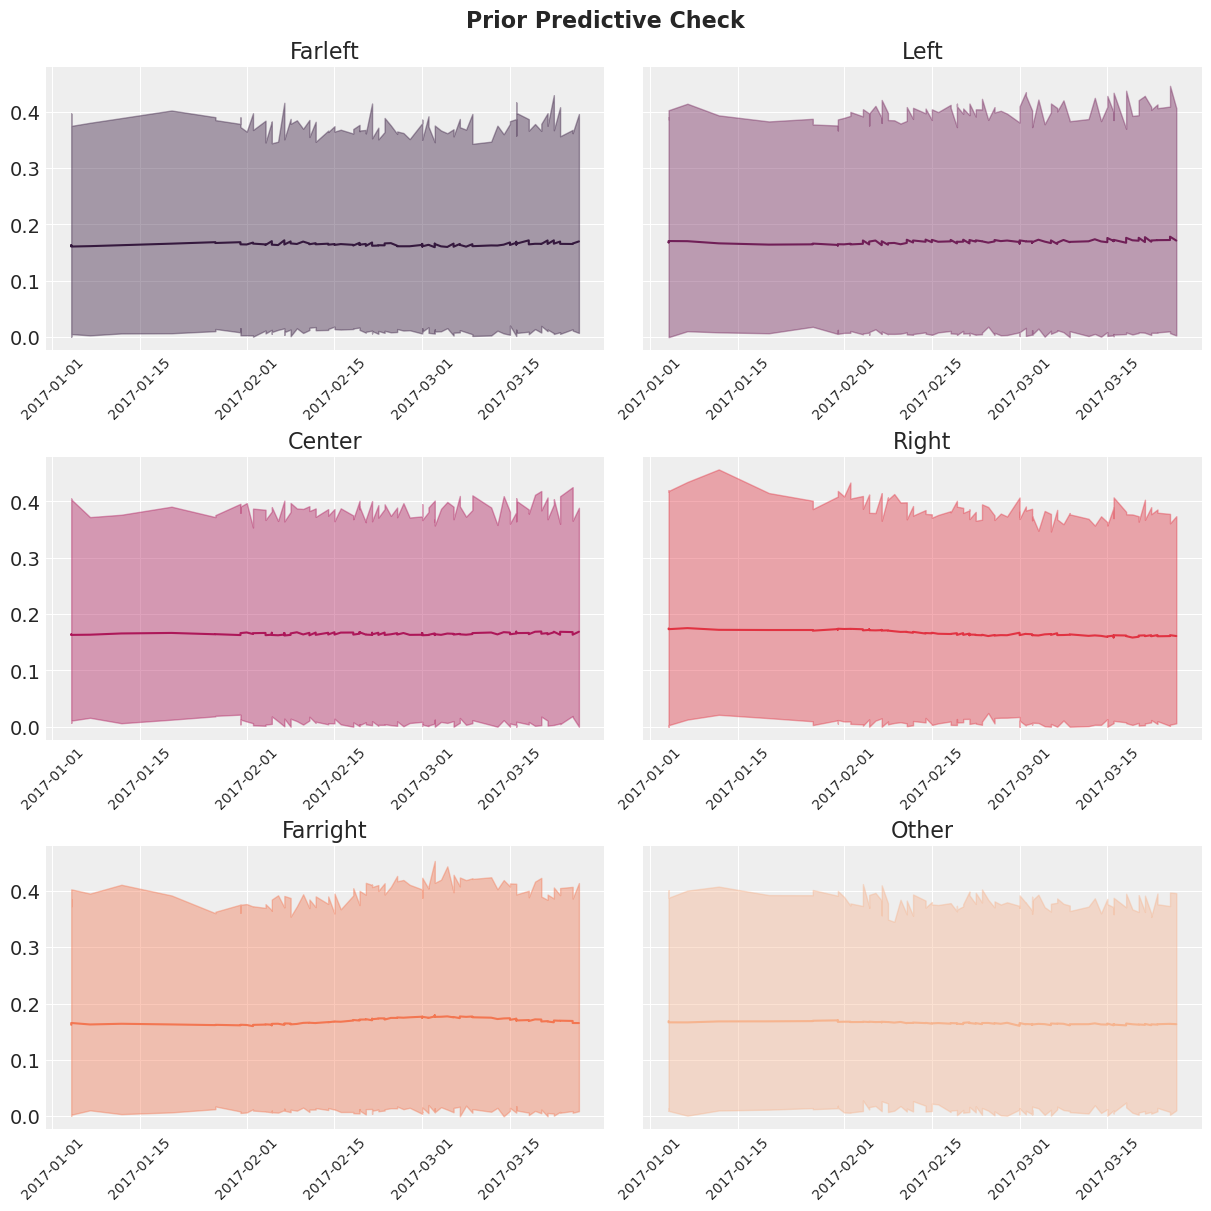

In [33]:
retrodictive_plot(idata, PARTIES_COMPLETE, polls_train, group="prior")

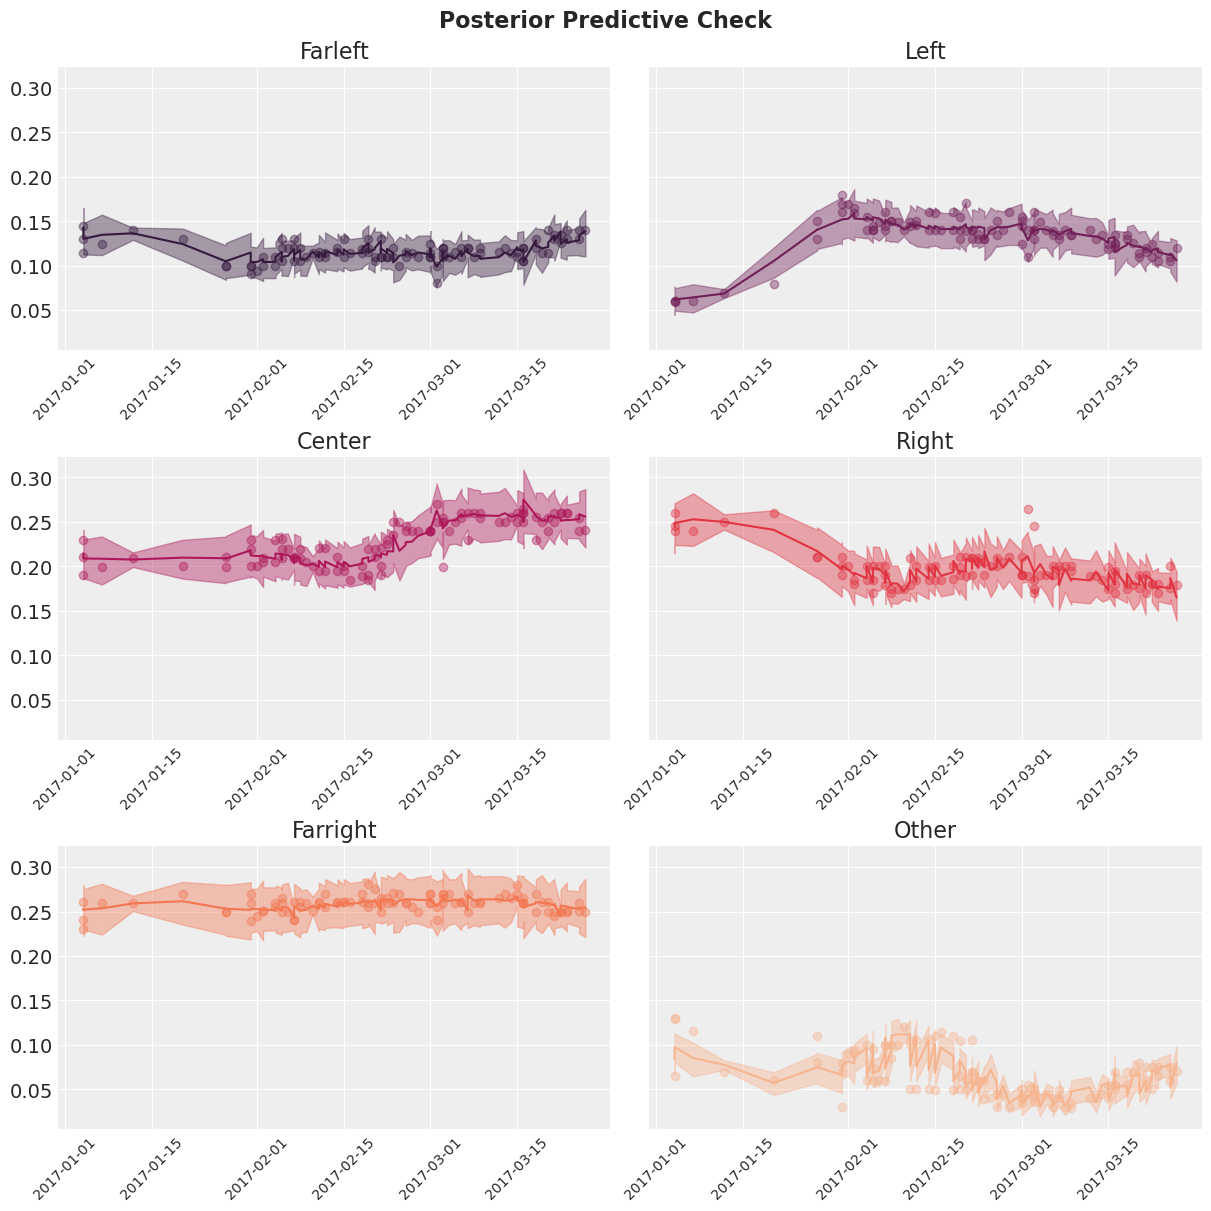

In [34]:
retrodictive_plot(idata, PARTIES_COMPLETE, polls_train)

In [35]:
with plain_mult:
    pm.set_data(
        {
            "pollster_idx": np.random.choice(pollster_id, size=len(estimated_days)),
            "observed_days_idx": estimated_days,
            "observed_N": np.random.choice(
                polls_train["samplesize"].values, size=len(estimated_days)
            ),
            "observed_polls": np.ones(
                (len(estimated_days), len(COORDS["parties_complete"])), dtype=int
            ),  # just a placeholder
        }
    )
    ppc = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )

In [36]:
PREDICTION_COORDS = {
    "observations": idata.posterior["estimated_days"],
    "estimated_days": idata.posterior["estimated_days"],
}
PREDICTION_DIMS = {
    "time_effect": ["estimated_days", "parties_complete"],
    "popularity": ["observations", "parties_complete"],
    "N_approve": ["observations", "parties_complete"],
}
with plain_mult:
    arviz.from_pymc3_predictions(
        ppc,
        idata_orig=idata,
        inplace=True,
        coords=PREDICTION_COORDS,
        dims=PREDICTION_DIMS,
    )

In [37]:
from posteriorplots import predictive_plot

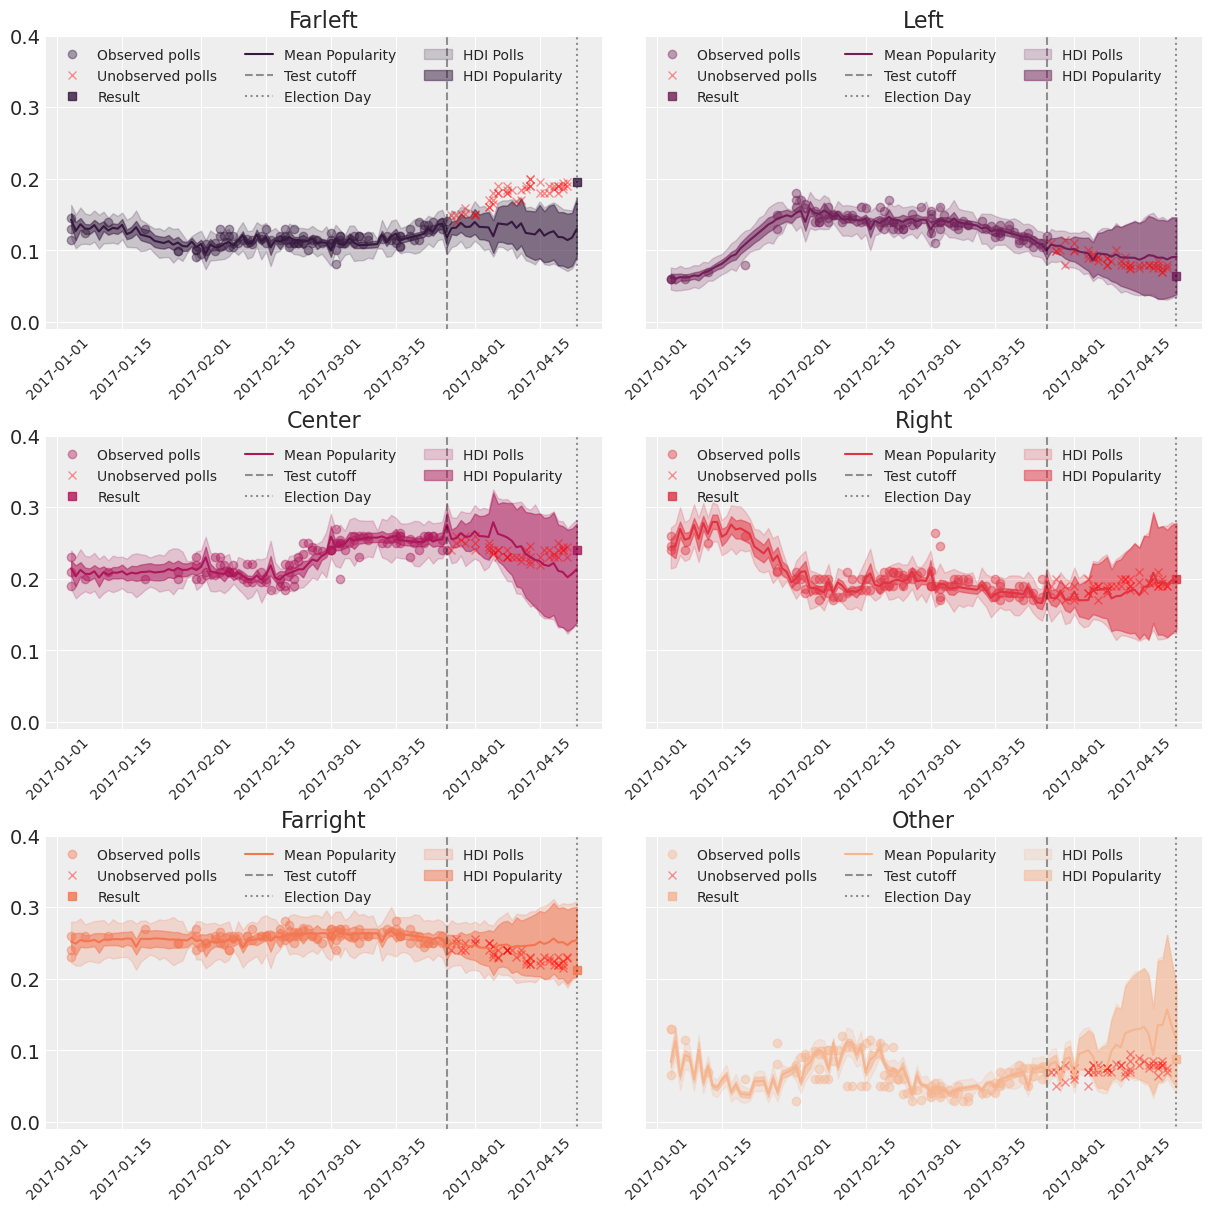

In [41]:
predictive_plot(
    idata, PARTIES_COMPLETE, polls_train, polls_test, results, ELECTION_DAY, TEST_CUTOFF
)

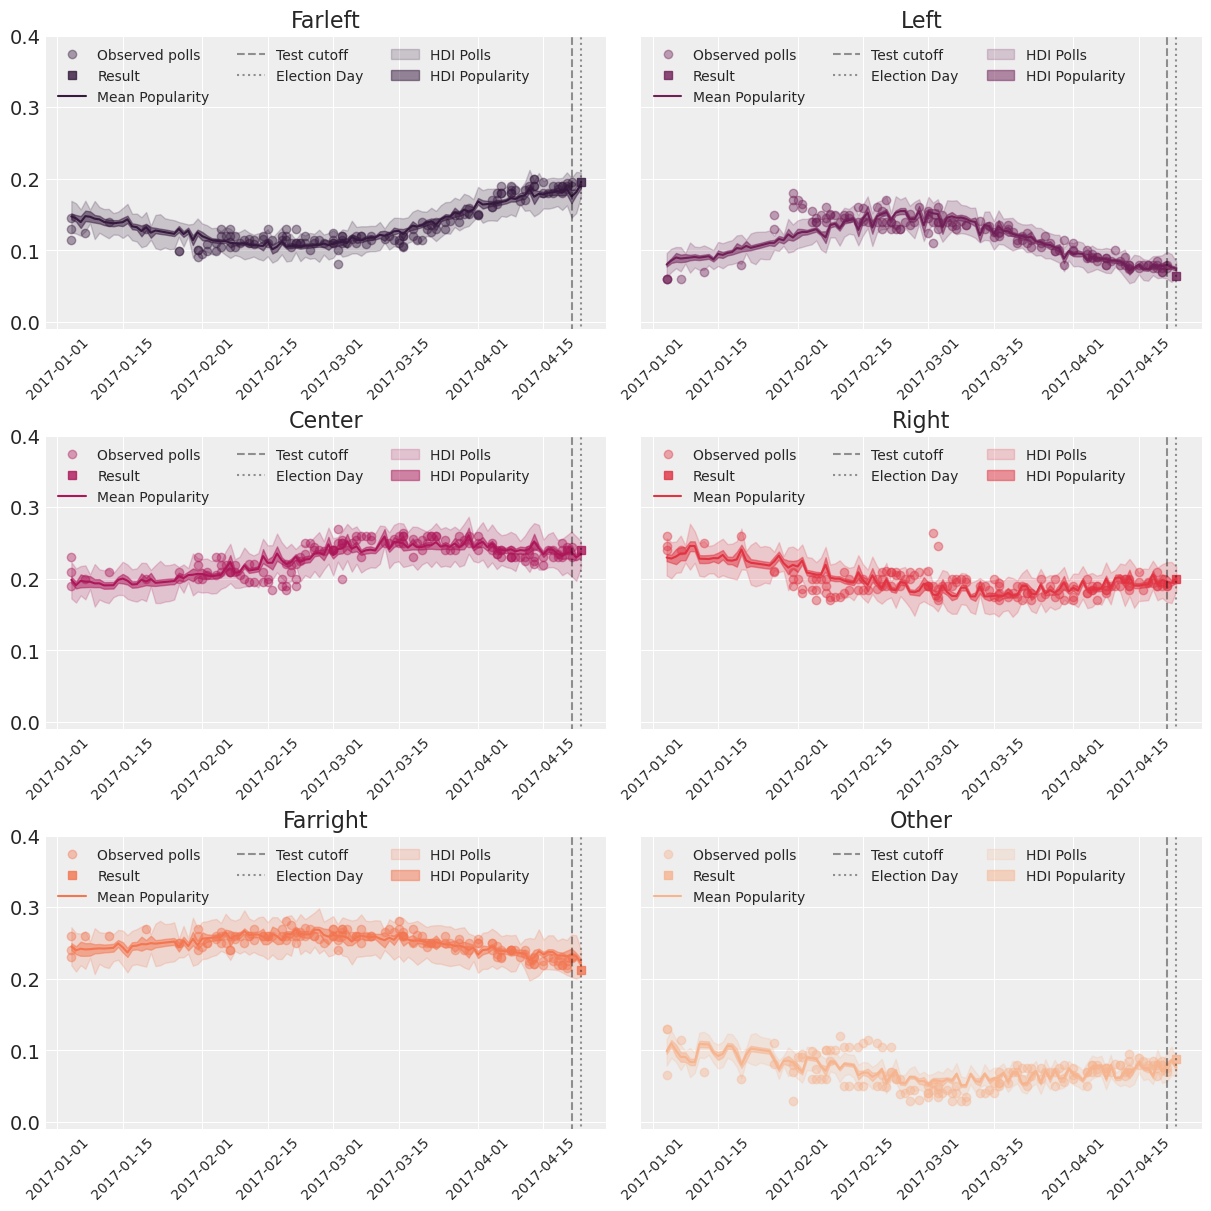

In [31]:
predictive_plot(idata)
plt.savefig("multinom_ppc.png")

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -a "Alexandre Andorra & Rémi Louf"

Author: Alexandre Andorra & Rémi Louf

Last updated: Fri Sep 10 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

arviz     : 0.11.2
matplotlib: 3.4.1
seaborn   : 0.11.1
xarray    : 0.17.0
pymc3     : 3.11.2
numpy     : 1.20.2
theano    : 1.1.2
pandas    : 1.2.4
scipy     : 1.6.2

